In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from sklearn import datasets
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
import csv

C:\Users\Admin\AppData\Local\Temp\ipykernel_186404\3789012242.py:8: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


In [2]:
SEED = 123
qasm_sim = AerSimulator()

# Dataset

In [3]:
my_data = genfromtxt('MNIST_CSV/mnist_train.csv', delimiter=',')

0.0


<Figure size 640x480 with 0 Axes>

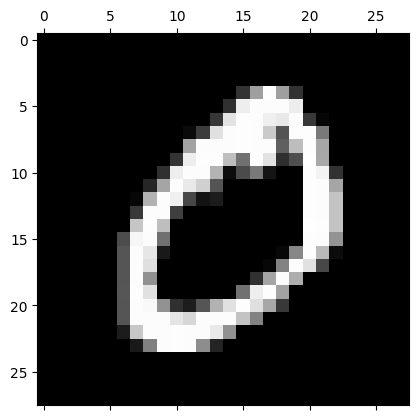

In [4]:
image = []
idx = 1
label = my_data[idx][0]
print(label)
for i in range(28):
    row = []
    for j in range(28):
        row.append(my_data[idx][i*28+j+1])
    image.append(row)
plt.gray()
plt.matshow(image)
plt.show()

In [5]:
x = np.array([])
y = []
threshold = 100
cnt = 0
for idx in range(len(my_data)):
    label = my_data[idx][0]
    if (label==0 or label==1):
            np.append(x,np.array(my_data[idx][1:783]))
            y.append(label)
            cnt = cnt + 1
            if (cnt==threshold):
                break
print(type(x))
print(len(y))

<class 'numpy.ndarray'>
100


<class 'numpy.ndarray'>


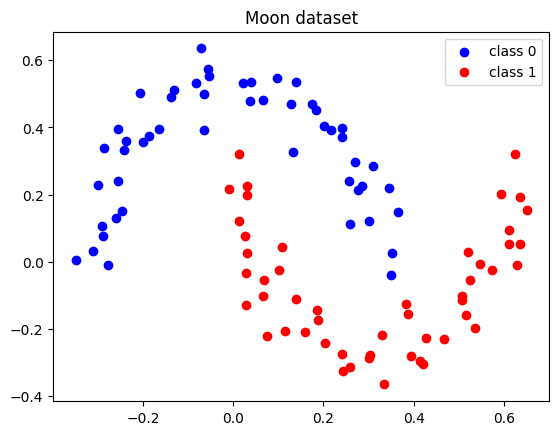

In [6]:
x,y = datasets.make_moons(n_samples=100, noise=0.1, random_state=SEED)

print(type(y))
# Normalizatin
x[:,0] = x[:,0] / (np.max(x[:,0]) - np.min(x[:,0]))
x[:,1] = x[:,1] / (np.max(x[:,1]) - np.min(x[:,1]))

num_classes = 2
num_features = 2
x_blue = x[y==0]
x_red = x[y==1]

plt.scatter(x_blue[:,0], x_blue[:,1], c='b', label="class 0")
plt.scatter(x_red[:,0], x_red[:,1], c='r', label="class 1")
plt.title("Moon dataset")
plt.legend()

In [7]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=SEED, stratify=y)

print(f"Train set size: {len(x_train)}")
print(f"Test set size:  {len(x_test)}")

Train set size: 80
Test set size:  20


# Data embedding circuits

In [8]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(num_features, 2, 'linear')
input_params = fmap_zz.parameters
fmap_zz.decompose().draw()#'mpl', scale=0.7)

┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
«     ┌─────────────┐                                          
«q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──
«     ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
«q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └─────────────┘└───┘└──────────────────────────────┘└───┘

In [9]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x[0])}).decompose().draw()#'mpl', scale=0.7)

┌───┐┌────────────┐                       ┌───┐┌────────────┐     »
q_0: ┤ H ├┤ P(0.57072) ├──■─────────────────■──┤ H ├┤ P(0.57072) ├──■──»
     ├───┤├────────────┤┌─┴─┐┌───────────┐┌─┴─┐├───┤├────────────┤┌─┴─┐»
q_1: ┤ H ├┤ P(0.45078) ├┤ X ├┤ P(16.659) ├┤ X ├┤ H ├┤ P(0.45078) ├┤ X ├»
     └───┘└────────────┘└───┘└───────────┘└───┘└───┘└────────────┘└───┘»
«                       
«q_0: ───────────────■──
«     ┌───────────┐┌─┴─┐
«q_1: ┤ P(16.659) ├┤ X ├
«     └───────────┘└───┘

# Ansatz

In [10]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(num_features, ['ry', 'rz'], 2, 'linear')
weights_params = ansatz_tl.parameters
ansatz_tl.decompose().draw()#'mpl', scale=0.7)

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├──■──┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├──■──┤ Ry(θ[8]) ├»
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├┤ X ├┤ Ry(θ[9]) ├»
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
«     ┌───────────┐
«q_0: ┤ Rz(θ[10]) ├
«     ├───────────┤
«q_1: ┤ Rz(θ[11]) ├
«     └───────────┘

In [11]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw()#'mpl', scale=0.7)

┌─────────────┐┌─────────────┐     ┌─────────────┐ ┌─────────────┐     »
q_0: ┤ Ry(0.27081) ├┤ Rz(0.79143) ├──■──┤ Ry(0.81441) ├─┤ Rz(0.37649) ├──■──»
     └─┬──────────┬┘├─────────────┤┌─┴─┐├─────────────┴┐├─────────────┤┌─┴─┐»
q_1: ──┤ Ry(0.66) ├─┤ Rz(0.48433) ├┤ X ├┤ Ry(0.044982) ├┤ Rz(0.78694) ├┤ X ├»
       └──────────┘ └─────────────┘└───┘└──────────────┘└─────────────┘└───┘»
«     ┌─────────────┐┌──────────────┐
«q_0: ┤ Ry(0.20282) ├┤ Rz(0.097148) ├
«     ├─────────────┤├─────────────┬┘
«q_1: ┤ Ry(0.36096) ├┤ Rz(0.91076) ├─
«     └─────────────┘└─────────────┘

In [12]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw()#'mpl', scale=0.7)

┌──────────────────────────┐»
q_0: ┤0                         ├»
     │  ZZFeatureMap(x[0],x[1]) │»
q_1: ┤1                         ├»
     └──────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                         ├
«     │  TwoLocal(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11]) │
«q_1: ┤1                                                                         ├
«     └──────────────────────────────────────────────────────────────────────────┘

# Primitives

For info, see https://docs.quantum.ibm.com/run/primitives

In [13]:
# for qiskit_ibm_runtime.Options, see https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.Options
options = {}
sampler = BackendSampler(backend=qasm_sim, options=options)
estimator = BackendEstimator(backend=qasm_sim, options=options)

# Quantum Neural Network

## SamplerQNN

In [14]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [15]:
var_circuit_with_meas = var_circuit.copy()
var_circuit_with_meas.measure_all()

In [16]:
paramShiftSampGrad = ParamShiftSamplerGradient(sampler=sampler)

sampler_qnn = SamplerQNN(sampler=sampler,
                         circuit=var_circuit_with_meas,
                         input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                        # (e.g. amplitude encoding) you will have to do some extra work!
                         weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                        # parameters of the embedding must be added
                         interpret=one_qubit_binary,
                         output_shape=2,
                         gradient=paramShiftSampGrad)

### Forward pass

In [17]:
# The result of the neural network on a forward pass.
output = sampler_qnn.forward(x, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 100 samples: (100, 2)
Output of the forward pass for first sample: [0.40332031 0.59667969]


### Backward pass

In [18]:
# The result of the neural network on a backward pass
_, weights_grad = sampler_qnn.backward(x, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")


Output shape for 100 samples: (100, 2, 12)
Output of the backward pass for first sample: [[-0.01464844 -0.08398438 -0.15576172 -0.16357422  0.22802734  0.02685547
  -0.00585938  0.03613281 -0.26074219  0.01318359 -0.00537109 -0.01416016]
 [ 0.01464844  0.08398438  0.15576172  0.16357422 -0.22802734 -0.02685547
   0.00585938 -0.03613281  0.26074219 -0.01318359  0.00537109  0.01416016]]


## EstimatorQNN

In [19]:
obs_parity = Pauli('Z' * num_features)
obs_one_qubit = Pauli('I' * (num_features - 1) + 'Z')
print(f"Parity observable: {obs_parity}")
print(f"First qubit observable: {obs_one_qubit}")

Parity observable: ZZ
First qubit observable: IZ


In [20]:
paramShiftEstGrad = ParamShiftEstimatorGradient(estimator=estimator)

estimator_qnn = EstimatorQNN(estimator=estimator,
                             circuit=var_circuit,
                             observables=obs_one_qubit,
                             input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                            # (e.g. amplitude encoding) you will have to do some extra work!
                             weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                            # parameters of the embedding must be added
                             gradient=paramShiftEstGrad)

### Forward pass

In [21]:
# The result of the neural network on a forward pass.
output = estimator_qnn.forward(x, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 100 samples: (100, 1)
Output of the forward pass for first sample: [-0.1875]


### Backward pass

In [22]:
# The result of the neural network on a backward pass
_, weights_grad = estimator_qnn.backward(x, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

Output shape for 100 samples: (100, 1, 12)
Output of the backward pass for first sample: [[-0.04394531 -0.171875   -0.3359375  -0.359375    0.42773438  0.07128906
   0.0078125   0.0546875  -0.54101562  0.00390625 -0.03808594  0.00097656]]


# Train a Neural Network Classifier

In [34]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[2]} converted to {y_train_1h[2]}")
print(f"Label {y_train[0]} converted to {y_train_1h[0]}")

print(len(y_train_1h.shape))
print(len(np.unique(y_train_1h)))
print(y_train_1h)
print(x_train)

Label 0 converted to [1 0]
Label 1 converted to [0 1]
2
2
[[0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]]
[[ 0.10171685 -0.02279776]
 [ 0.11432906 -0.20645673]
 [ 0.30210652  0.12111455]
 [ 0.63633919  0.19404409]
 [-0.16496574  0.39669478]
 [ 0.46813687 -0.22864962]
 [ 0.39350239 -0.28025641]
 [ 0.1745284   0.47069817]
 [-0.28988621  0.0770874 ]
 [ 0.03816235  0.47827365]
 [ 0.18331907  0.45187054]
 [ 0.57302841 -0.02539684]
 [ 0.30146663 -0.28692462]
 [-0.25606045  0.2401672 ]
 [-

In [37]:
def spsa_callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)
        # print(f"SPSA Epoch {len(spsa_loss_recorder)}: {fval:.5f}")

In [38]:
max_itr = 40
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback)
spsa_loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)
print(type(x_train))
vqc = vqc.fit(x_train, y_train_1h)

<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Training loss')

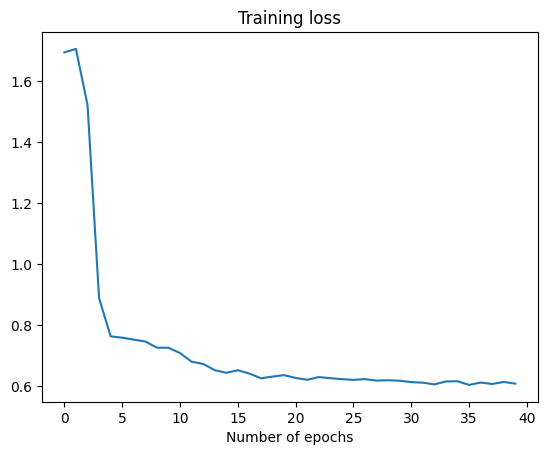

In [39]:
plt.plot(spsa_loss_recorder)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [40]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.8125
Score on the test set 0.7


In [28]:
y_train_pred = vqc.predict(x_train)
y_test_pred = vqc.predict(x_test)

In [29]:
train_pred_acc = np.all(y_train_pred == y_train_1h, axis=1)
test_pred_acc = np.all(y_test_pred == y_test_1h, axis=1)

In [30]:
x_all = np.concatenate((x_train, x_test))
y_all= np.concatenate((y_train_1h, y_test_1h))
y_pred_acc_all = np.concatenate((train_pred_acc, test_pred_acc))

x_b = x_all[np.all(y_all == [1, 0], axis=1)]
x_b_good = x_b[(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]
x_b_bad = x_b[np.logical_not(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]

x_r = x_all[np.all(y_all == [0, 1], axis=1)]
x_r_good = x_r[(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]
x_r_bad = x_r[np.logical_not(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]

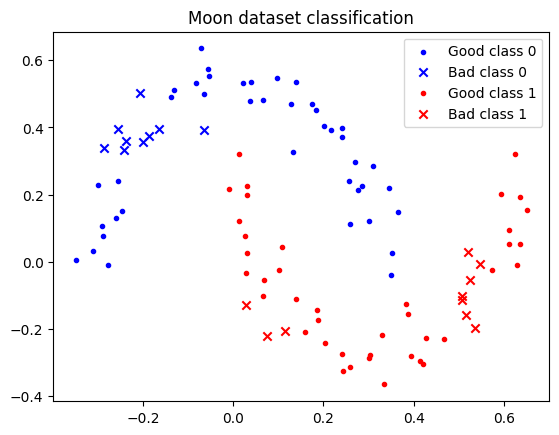

In [31]:
plt.scatter(x_b_good[:,0], x_b_good[:,1], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,0], x_b_bad[:,1], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,0], x_r_good[:,1], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,0], x_r_bad[:,1], c='r', marker="x", label="Bad class 1")

plt.title("Moon dataset classification")
plt.legend()